In [1]:
from PIL import Image, ImageDraw, ImageOps
from PIL import GifImagePlugin
import vtracer
import svg_to_gcode
from svg_to_gcode.svg_parser import parse_file, parse_string
from svg_to_gcode.compiler import Compiler, interfaces

In [2]:
ratios = { 1 : { 'nom' : "1.66", 'ratio' : 5/3, 'l' : 12.39, 'h' : 7.49 },
           2 : { 'nom' : "1.85", 'ratio' : 37/20, 'l' : 12.39, 'h' : 6.69 },
           3 : { 'nom' : "2.40", 'ratio' : 12/5, 'l' : 12.39, 'h' : 5.16 } }
# Choisir quel format on veut utiliser ici:
ratio = ratios[1]
largeur, hauteur = ratio['l'], ratio['h']
# Travail en micromètres (on ne divise pas les micromètres)
largeur, hauteur = (int(v*1000) for v in (largeur, hauteur))
fond = (200,50,200)  # Couleur pour le fond pour les représentations à l'écran uniquement

In [3]:
def pellicule(sequence, pixels=120, nombre = 0):
    """Crée une image de la pellicule de largeur pixels à partir d'une séquence.
    Prend uniquement nombre images de la séquence (0: toutes les images)"""
    if nombre == 0:
        nombre = len(sequence)
    seq = [int(r * (len(sequence) - 1) / (nombre - 1)) for r in range(nombre)]
    pixelsl = pixels
    pixelsh = int(pixels * hauteur / largeur)
    p = Image.new(mode="RGB", size=(pixelsl, (pixelsh + 1) * nombre - 1))
    p.paste( fond, (0, 0, *p.size))
    for i in range(nombre):
        img = sequence[seq[i]]
        apercu = img.copy()
        apercu.thumbnail((pixelsl, pixelsh))
        lreel, hreel = apercu.size
        decalagel = int((pixelsl - lreel) / 2)
        decalageh = int((pixelsh - hreel) / 2)
        p.paste(apercu, (decalagel, decalageh +  (pixelsh + 1) * i))
    return p

La séquence comporte 98 images.
Résumé


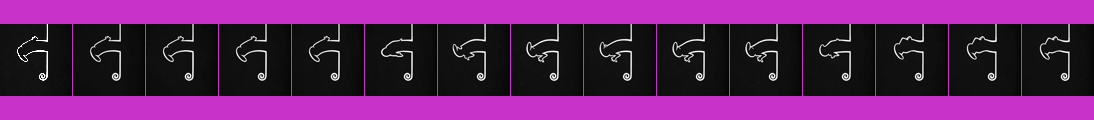

In [4]:
source = "lalinea.gif"
sequence_gif = Image.open(source)
if not sequence_gif.is_animated:
    print("une seule image - ce n'est pas une animation")
else:
    print(f"La séquence comporte {sequence_gif.n_frames} images.")
print("Résumé")
sequence = []
for i in range(sequence_gif.n_frames):
    sequence_gif.seek(i)
    img = sequence_gif.copy()
    sequence.append(img)
    
display(pellicule(sequence, 120, 15).rotate(90, expand=True))

In [5]:
def H_vers_RGB(H):
    """Roue chromatique: teinte H entre 0 et 360, renvoie la couleur en RGB 0 à 1.0
    """
    if H < 60:
        return(1.0,H/60.,0.)
    elif H < 120:
        return (1.-(H-60.)/60.,1,0.)
    elif H < 180:
        return (0.,1.,(H-120.)/60.)
    elif H < 240:
        return (0.,1. - (H-180.)/60, 1.0)
    elif H < 300:
        return ((H-240.)/60., 0., 1.)
    else:
        return (1., 0.1, 1.-(H-300.)/60.)


def H_vers_RGB_entier(H):
    v = H_vers_RGB(H)
    return tuple((int(t*255) for t in v))



def colorise(image, couleur):
    def choisit(pixel):
        r, v, b = pixel
        if (r + v + b) < 300:
            return couleur
        else:
            return (255, 255, 255)
    resultat = list(choisit(pixel) for _, pixel in enumerate(image.getdata()))
    image.putdata(resultat)
    return image
        


def traitement_couleur(image, numero=0, total=0):
    """transforme les couleur. Cette opération est spécifique à chaque GIF.
    """
    image = ImageOps.invert(image.convert("RGB"))
    if total !=0:
        image = colorise(image, H_vers_RGB_entier(numero*360/total))
        
    return image

In [6]:
def applique_traitement_couleur(sequence):
    n = len(sequence)
    s_post = [traitement_couleur(sequence[i], i, n) for i in range(n)]    
    return s_post

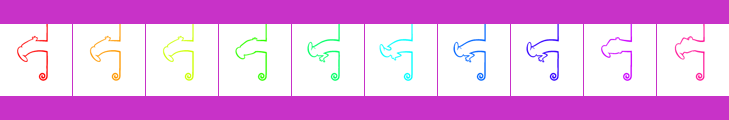

In [7]:
s_post = applique_traitement_couleur(sequence[0:98:10])
pellicule(s_post).rotate(90, expand=True)

In [8]:
def separer_couleurs(sequence):
    s_post_rouge, s_post_vert, s_post_bleu = [], [], []
    for image in sequence:
        r, v, b = Image.Image.split(image)
        s_post_rouge.append(r)
        s_post_vert.append(v)
        s_post_bleu.append(b)
    return s_post_rouge, s_post_vert, s_post_bleu

In [9]:
s_post_rouge, s_post_vert, s_post_bleu = separer_couleurs(s_post) 

In [10]:
gcode_compiler = Compiler(interfaces.Gcode,
                          cutting_speed=1000,
                          movement_speed=700,
                          pass_depth=5)

In [11]:
img = s_post_vert[0]
output = "output.svg"

In [12]:
pixels: list[tuple[int, int, int, int]] = list(img.convert("RGBA").getdata())
svg_str: str = vtracer.convert_pixels_to_svg(pixels, img.size)
with open(output, "w") as f:
  f.write(svg_str)

In [13]:
svg_to_gcode.TOLERANCES["approximation"] = 0.1
print(svg_to_gcode.TOLERANCES)

courbes = parse_string(svg_str, )
gcode_compiler.append_curves(courbes)
gcode_compiler.compile_to_file("drawing.gcode")

{'approximation': 0.1, 'input': 0.001, 'operation': 1e-06}


# Minimal example: use all default values, generate a multicolor SVG
vtracer.convert_image_to_svg_py(inp, out)

# Single-color example. Good for line art, and much faster than full color:
vtracer.convert_image_to_svg_py(inp, out, colormode='binary')

# Convert from raw image bytes
input_img_bytes: bytes = get_bytes() # e.g. reading bytes from a file or a HTTP request body
svg_str: str = vtracer.convert_raw_image_to_svg(input_img_bytes, img_format = 'jpg')

# Convert from RGBA image pixels
from PIL import Image
img = Image.open(input_path).convert('RGBA')
pixels: list[tuple[int, int, int, int]] = list(img.getdata())
svg_str: str = vtracer.convert_pixels_to_svg(pixels)

# All the bells & whistles, also applicable to convert_raw_image_to_svg and convert_pixels_to_svg. 
vtracer.convert_image_to_svg_py(inp,
                                out,
                                colormode = 'color',        # ["color"] or "binary"
                                hierarchical = 'stacked',   # ["stacked"] or "cutout"
                                mode = 'spline',            # ["spline"] "polygon", or "none"
                                filter_speckle = 4,         # default: 4
                                color_precision = 6,        # default: 6
                                layer_difference = 16,      # default: 16
                                corner_threshold = 60,      # default: 60
                                length_threshold = 4.0,     # in [3.5, 10] default: 4.0
                                max_iterations = 10,        # default: 10
                                splice_threshold = 45,      # default: 45
                                path_precision = 3          # default: 8
                                )